In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
import os
from funcs import *
from simulator import *
import seaborn as sns

In [2]:
entrada = open('in/e.txt', 'r')
saida = open('out/e.out', 'w')

D,I,S,V,F, sts, cars, inters = pega_input(entrada.readline)
schedule = sol_batata(D,I,S,V,F, sts, cars, inters)
output = form_out(schedule)[:-1]
total, bkp_cars = score(D, F, sts, cars, inters, schedule)
print(f'score: {total:,}')

score: 661,797


In [3]:
# Cada linha é um carro, cada coluna é uma estatística do carro

data = []
cars.update(bkp_cars)
for car in cars:
    #print(cars[car])
    path = cars[car]['path']
    qtde_ruas = len(path) - 1
    
    total_tam_ruas = 0
    for st in path[1:]:
        dims = sts[st]['size']
        tam_rua = dims[2]
        total_tam_ruas += tam_rua
        #print(f'rua {st} : {dims}')
        
    ruas_intersec = 0
    for car2 in cars:
        path1 = set(path)      
        
        path2 = cars[car2]['path']
        #qtde_ruas = len(path2) - 1
        path2 = set(path2)
        
        intersecs = len(path1.intersection(path2))
        ruas_intersec += intersecs
        
    sts_with_intersect = 0#{}
    for st in path:
        #st_has_intersect[st] = False 
        for car2 in cars:
            path = cars[car]['path'] 
            if st in path:
                #st_has_intersect[st] = True
                sts_with_intersect += 1
                break
    #print('sthasinter', st_has_intersect)
    score_car = cars[car]['score']
    #print(f'{car} : ruas: {qtde_ruas}, tamanhototal: {total_tam_ruas}')
    data.append([ car, qtde_ruas, total_tam_ruas, ruas_intersec, sts_with_intersect, score_car ])
df = pd.DataFrame(data, columns=['Carro', 'Ruas', 'Tamanho total', 'Ruas em comum', 'Ruas com intersec', 'Score'])

In [4]:
df.describe()

,Carro,Ruas,Tamanho total,Ruas em comum,Ruas com intersec,Score
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,499.500000,0.645000,31.831000,5.241000,1.645000,661.797000
std,288.819436,1.559297,78.211761,5.199033,1.559297,400.279407
min,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,249.750000,0.000000,0.000000,2.000000,1.000000,532.250000
50%,499.500000,0.000000,0.000000,4.000000,1.000000,775.000000
75%,749.250000,0.000000,0.000000,5.000000,1.000000,981.000000
max,999.000000,9.000000,467.000000,39.000000,10.000000,1173.000000


In [5]:
filtro = (df['Ruas'] == 1)

In [6]:
df[filtro].shape

(58, 6)

array([[<AxesSubplot:title={'center':'Carro'}>,
        <AxesSubplot:title={'center':'Ruas'}>],
       [<AxesSubplot:title={'center':'Tamanho total'}>,
        <AxesSubplot:title={'center':'Ruas em comum'}>],
       [<AxesSubplot:title={'center':'Ruas com intersec'}>,
        <AxesSubplot:title={'center':'Score'}>]], dtype=object)

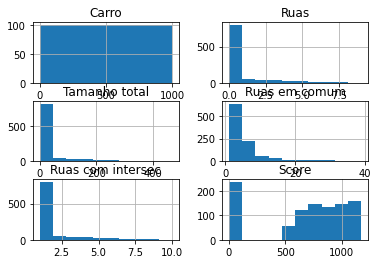

In [7]:
df.hist()

In [8]:
#def 

# for col in df.columns:
#     df.plot.pie(y=col, figsize=(5, 5))
#df.plot.pie(y='Ruas com intersec', figsize=(5, 5))

#df['Ruas entre x e y'] = df['Ruas com intersec']

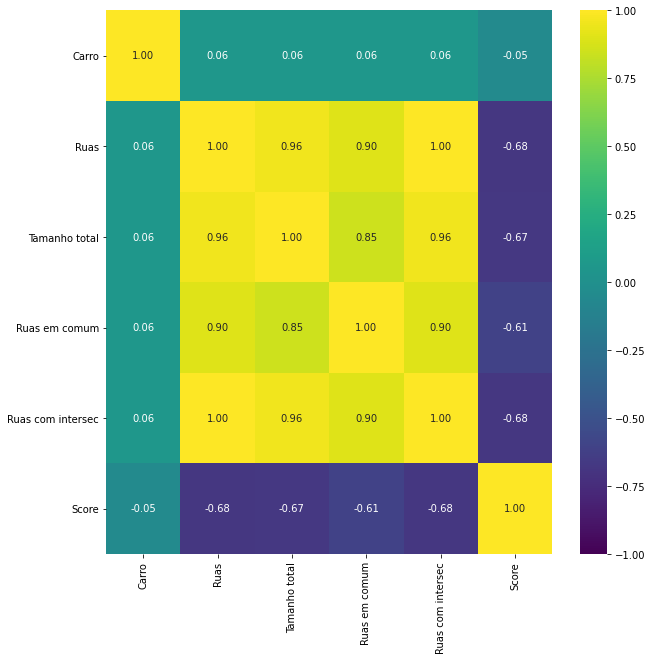

In [9]:
plt.figure(figsize=(10, 10))
corr = df.corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='viridis', vmin=-1, vmax=1);